In [1]:
%matplotlib inline
import numpy as np
import sys
import scipy
sys.path.append('../datasets')
sys.path.append('../optimization')
sys.path.append('../util')
import eval as E
import problem as P

In [159]:
def mse_per_domain(prob_te, ind=None):
    if ind is None:
        ind = np.array(range(len(prob_te.y)), dtype=int)
    mse_te = np.zeros(prob_te.p)
    for k in range(prob_te.p):
        mse_te[k] = ((prob_te.h[ind,k]-prob_te.y[ind])**2).sum()/len(ind)
    return mse_te

def mse_unif_cvx(prob_te, ind=None):
    if ind is None:
        ind = np.array(range(len(prob_te.y)), dtype=int)
    return ((prob_te.h[ind,:].sum(axis=1)/prob_te.p-prob_te.y[ind])**2).sum()/len(ind)    

def compute_all_mse(z, prob_te, ind=None):
    if ind is None:
        ind = np.array(range(len(prob_te.y)), dtype=int)
    #z_unif = np.repeat(1.0/prob_te.p, prob_te.p)
    mse_te = np.zeros(prob_te.p+1)
    mse_te[:prob_te.p] = mse_per_domain(prob_te, ind=ind)
    #mse_te[prob_te.p] = mse_unif_cvx(prob_te, ind=ind)
    #mse_te[prob_te.p+1] = prob_te.compute_sq_err(z_unif, ind=ind)
    mse_te[prob_te.p] = prob_te.compute_sq_err(z, ind=ind)
    return mse_te

In [3]:
def obj_direct(z,prob):
    Dz,Jz,Kz,hz = prob.compute_DzJzKzhz(z)
    loss = np.zeros(prob.p)
    err = (hz-prob.y)**2
    LDzhz = (Dz*err).sum()
    for k in range(prob.p):
        loss[k] = (prob.D[:,k]*err).sum()
    return loss - LDzhz

In [298]:
import sentiment_analysis as SA
#import sentiment_analysis_randgen as SA
reload(SA)
#datadir = '/data/sentiment_analysis2/domain_adaptation/randgen/'
datadir = '/data/sentiment_analysis2/domain_adaptation/'

mO = 16
ng = 1
eta = 1e-50
eta2 = 1e-50
domains=('kitchen', 'dvd', 'books', 'electronics')
src_ind = [0,3]
tgt_ind = [0,3] #[1,2]
src_dom = [domains[i] for i in src_ind]
tgt_dom = [domains[i] for i in tgt_ind]
print 'Source Domains', src_dom
print 'Target Domains', tgt_dom

Source Domains ['kitchen', 'electronics']
Target Domains ['kitchen', 'electronics']


In [307]:
reload(P)
reload(SA)
# old data use delta=1e11
# new data use delta=1e3
numS = 3
z_unif = np.repeat(1.0/len(src_dom), len(src_dom))
te_err_sp = np.zeros([numS-1, len(src_dom)+1])
for sp in range(1,numS):
    DP = SA.sm_problem(datadir=datadir, minO=mO, ngram=ng, 
                    split=sp, sources=src_dom, dset='train',eta=eta)
    DP_te = SA.sm_problem(datadir=datadir, minO=mO, ngram=ng, 
                    split=sp, sources=domains,dset='test',eta=eta2)
    DP_te.subsample(src_ind, tgt_ind)
    prob = P.ConvexConcaveProblem(DP)
    prob_te = P.ConvexConcaveProblem(DP_te)
    solver = P.ConvexConcaveSolver(prob)
    z_iter,o_iter,err_iter = solver.solve(step=2000,delta=1e-7)
    te_err_sp[sp-1,:] = compute_all_mse(z_iter[:,-1],prob_te)
    
te_err_sp = te_err_sp[:sp-1,:]

Iter 0: obj val=0.07281  err val=0.9868
Iter 200: obj val=0.06236  err val=0.9865
Iter 400: obj val=0.05192  err val=0.9861
Iter 600: obj val=0.04148  err val=0.9855
Iter 800: obj val=0.03104  err val=0.9848
Iter 1000: obj val=0.0206  err val=0.9838
Iter 1200: obj val=0.01016  err val=0.9818
Iter 1400: obj val=0.000199  err val=0.971
Iter 1600: obj val=0  err val=0.9327
Iter 1800: obj val=0  err val=0.9327
Iter 2000: obj val=0  err val=0.9327
Learned z [ 1.  0.]
Final Obj=0

Iter 0: obj val=0.05487  err val=0.988
Iter 200: obj val=0.04894  err val=0.9878
Iter 400: obj val=0.04301  err val=0.9875
Iter 600: obj val=0.03708  err val=0.9873
Iter 800: obj val=0.03115  err val=0.9869
Iter 1000: obj val=0.02522  err val=0.9865
Iter 1200: obj val=0.01929  err val=0.9859
Iter 1400: obj val=0.01336  err val=0.9852
Iter 1600: obj val=0.007426  err val=0.9839
Iter 1800: obj val=0.001495  err val=0.9806
Converged: objective is less than threshold (-8.882e-16)
Learned z [ 1.  0.]
Final Obj=-8.882e-1

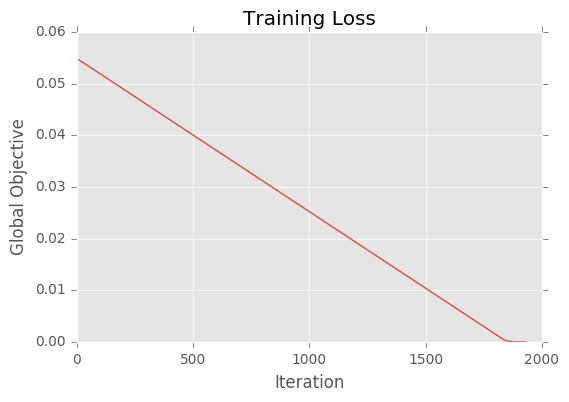

In [308]:
plt.plot(range(len(o_iter)),o_iter)
plt.xlabel('Iteration')
plt.ylabel('Global Objective')
plt.title('Training Loss')

## Compute mean and std MSE over uniform test

In [309]:
mu_mse = te_err_sp.mean(axis=0)
e_mse = te_err_sp.std(axis=0) 

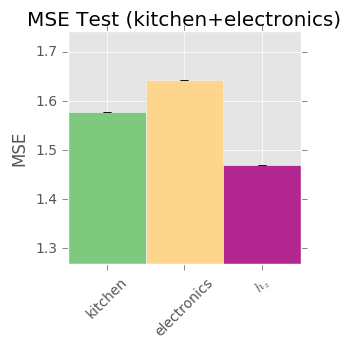

In [310]:
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
from matplotlib import rc
#rc = matplotlib.rcParams
#matplotlib.rcParams['text.usetex'] = True
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=False)


plt.style.use('ggplot')
cm = matplotlib.cm

fig = plt.figure(figsize=[3,3])
ax = fig.add_subplot(111)
#plt.grid()

ne = DP.p+1
ind = np.array(range(ne))
width=1.5
tick_loc = np.zeros(ne)
alg_names = DP.sources + ['$h_z$']
for j in range(ne):
    ax.bar(ind[j], mu_mse[j],
           width=1, label=alg_names[j],color=cm.Accent(float(j)/ne))
    ax.errorbar(ind[j]+.5, mu_mse[j], yerr=e_mse[j], ecolor='k')

ax.set_xticks(np.arange(ne)+0.5)
ax.set_xticklabels(alg_names, rotation=45)
label = '+'.join(DP_te.sources)
ax.set_ylim([max(0,min(mu_mse)-.2),max(mu_mse) + 0.1])
plt.ylabel(r'MSE')
plt.title(r'MSE Test ({:s})'.format(label))

## Brute Force Find z

In [311]:
m = np.arange(0.001, 1, 0.001)
loss_val_tr = np.zeros(len(m))
loss_val_te = np.zeros(len(m))
l_val_tr = np.zeros(len(m))
err_z_tr = np.zeros(len(m))
err_z_te = np.zeros(len(m))
y = DP.get_true_values()
y_te = DP_te.get_true_values()
for i,m_val in enumerate(m):
    zi = np.array([m_val, (1-m_val)])
    loss_val_tr[i] = max(prob.compute_obj(zi))
    loss_val_te[i] = max(prob_te.compute_obj(zi))
    err_z_tr[i] = prob.compute_sq_err(zi)
    err_z_te[i] = prob_te.compute_sq_err(zi)
    l_val_tr[i] = max(obj_direct(zi,prob))

Learned z value 0.962468993803 1.44484759566 [  1.00000017e+00   7.91117851e-08]
Best Train z 0.00243554315113 [0.999, 0.0010000000000000009]
Best Test z 0.00398548905646 [0.999, 0.0010000000000000009]


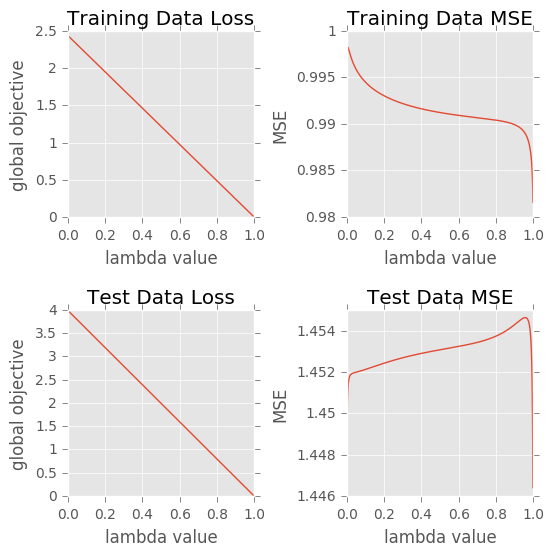

In [312]:
fig = plt.figure(figsize=[6,6])
fig.subplotpars.wspace = 0.5
fig.subplotpars.hspace = 0.5

ax = fig.add_subplot(221)
#ax.plot(m, loss_val_tr)
ax.plot(m, l_val_tr)
plt.xlabel('lambda value')
plt.ylabel('global objective')
plt.title('Training Data Loss')
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.5g'))

ax = fig.add_subplot(222)
ax.plot(m, err_z_tr)
plt.xlabel('lambda value')
plt.ylabel('MSE')
plt.title('Training Data MSE')
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.5g'))

ax = fig.add_subplot(223)
ax.plot(m, loss_val_te)
plt.xlabel('lambda value')
plt.ylabel('global objective')
plt.title('Test Data Loss')
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.5g'))

ax = fig.add_subplot(224)
ax.plot(m, err_z_te)
plt.xlabel('lambda value')
plt.ylabel('MSE')
plt.title('Test Data MSE')
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.5g'))

etr=prob.compute_sq_err(z_iter[:,-1])
ete=prob_te.compute_sq_err(z_iter[:,-1])
print 'Learned z value', etr,ete,z_iter[:,-1].flatten()
print 'Best Train z',l_val_tr.min(), [m[l_val_tr.argmin()], (1-m[l_val_tr.argmin()])]
print 'Best Test z',loss_val_te.min(), [m[loss_val_te.argmin()], (1-m[loss_val_te.argmin()])]

## Experiment with different lambda test mixtures

In [313]:
l_list = np.arange(0.01,1,0.01)
te_err_l = np.zeros([len(l_list),6])
alg_names = DP_te.sources + ['$\sum_i \lambda_i h_i$', '$h_{\lambda}$', '$h_z$']
N = 400
ind_a = np.array(range(N), dtype=int)
ind_b = np.array(range(N,2*N), dtype=int)
zi = z_iter[:,-1] #np.array([.5, .5])

for i,l in enumerate(l_list):
    #print int(round(N*l)), int(round(N*(1-l)))
    ind = np.hstack([ind_a[:int(round((N*l)))], ind_b[:int(round(N*(1-l)))]])
    te_err_l[i,:DP_te.p] = all_mse[:DP_te.p]
    all_mse = compute_all_mse(zi,prob_te,ind=ind)
    zl = np.array([l, (1-l)])
    l_weighted = prob_te.h[ind,:] * np.tile(zl, [len(ind),1])
    te_err_l[i,DP_te.p] = ((l_weighted.sum(axis=1)-prob_te.y[ind])**2).sum()/len(ind)
    te_err_l[i,DP_te.p+1] = prob_te.compute_sq_err(zl,ind=ind)
    te_err_l[i,DP_te.p+2] = all_mse[-1]

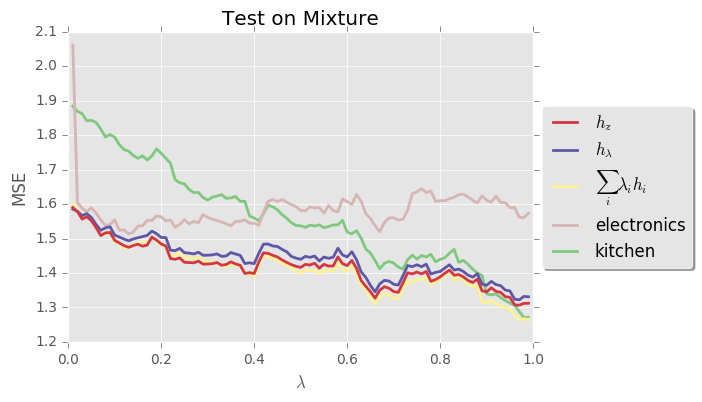

In [314]:
fig = plt.figure()
ax = fig.add_subplot(111)
na = len(alg_names)
for k in range(na):
    ax.plot(l_list, te_err_l[:,k], color=cm.Accent(float(k)/na), 
            label=alg_names[k], linewidth=2)
#ax.plot(l_list, te_err_l[:,k+1], color=cm.Accent(float(k+1)/na), 
#            label='lamda weight', linewidth=2)
    
rc('text', usetex=True)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1] , loc='center left',
         bbox_to_anchor=(1.0, .50),fancybox=True, shadow=True, ncol=1)

plt.xlabel('$\lambda$')
rc('text', usetex=False)
plt.ylabel('MSE')
plt.title('Test on Mixture')

## Below is Dev code

In [280]:
Dz,Jz,Kz,hz = prob_te.compute_DzJzKzhz(z_iter[:,-1])
print hz[:5]
print prob_te.h[:5,:].transpose()
print z_iter[:,-1]

sc = prob_te.D.sum(axis=1)
D_sc = (prob_te.D + 1e-200) / (np.tile(sc[:,np.newaxis],[1,2])+1e-200)

Dh = D_sc * prob_te.h 

prob_te.etaU
h_avg = prob_te.h.sum(axis=1) / 2
print h_avg[:5]
zDh_n = z_iter[0,-1]*Dh[:,0] + z_iter[1,-1]*Dh[:,1]
zD_d =  z_iter[0,-1]*D_sc[:,0] + z_iter[1,-1]*D_sc[:,1]
print zDh_n[:5]
print prob_te.etaU * h_avg[:5]
print Dh[:5,:]
print zD_d[:5]

print zDh_n[:5]/zD_d[:5]
hz_new = zDh_n / zD_d #(zDh_n+ 1e-100*h_avg)/(zD_d+1e-100)

print 'hz mse:',((hz-prob_te.y)**2).sum()/len(prob_te.y)
print 'hz_new mse:',((hz_new-prob_te.y)**2).sum()/len(prob_te.y)

[ 1.71986     4.92121     3.24534992  4.3279      4.48630058]
[[ 2.70296  4.92121  3.03586  5.15937  4.11058]
 [ 1.71986  3.27532  3.24535  4.3279   4.86147]]
[ 0.0027561  0.9972439]
[ 2.21141   4.098265  3.140605  4.743635  4.486025]
[ 1.7151199   0.01356334  3.23597271  4.31597188  4.84807131]
[  1.38213125e-153   2.56141563e-153   1.96287813e-153   2.96477187e-153
   2.80376562e-153]
[[  5.38332652e-82   1.71986000e+00]
 [  4.92121000e+00   7.25131839e-68]
 [  4.07023622e-04   3.24491489e+00]
 [  2.66863473e-62   4.32790000e+00]
 [  8.92886807e-44   4.86147000e+00]]
[ 0.9972439   0.0027561   0.99711057  0.9972439   0.9972439 ]
[ 1.71986     4.92121     3.24534992  4.3279      4.86147   ]
hz mse: 1.89070158983
hz_new mse: 1.9519360454


In [94]:
def LDkhz(k,z,prob):
    Dz,Jz,Kz,hz = prob.compute_DzJzKzhz(z)
    err = (hz-prob.y)**2
    return (prob.D[:,k] * err).sum()

def LUhz(z,prob):
    Dz,Jz,Kz,hz = prob.compute_DzJzKzhz(z)
    err = (hz-prob.y)**2
    return (prob.etaU * err).sum()

def LDzhz(z,prob):
    Dz,Jz,Kz,hz = prob.compute_DzJzKzhz(z)
    err = (hz-prob.y)**2
    return (Dz * err).sum()
    
def get_fk(k,z,prob):
    Dz,Jz,Kz,hz = prob.compute_DzJzKzhz(z)
    Lk = LDkhz(k,z,prob)
    EDklogKz = (prob.D[:,k]*np.log(Kz)).sum()
    return Lk - 2*prob.M*EDklogKz

def get_gk(k,z,prob):
    Dz,Jz,Kz,hz = prob.compute_DzJzKzhz(z)
    EDklogKz = (prob.D[:,k]*np.log(Kz)).sum()
    return -2*prob.M*EDklogKz

def get_f(z,prob):
    Dz,Jz,Kz,hz = prob.compute_DzJzKzhz(z)
    Lz = LDzhz(z,prob)
    LetaU = LUhz(z,prob)
    EUlogKz = prob.etaU * (np.log(Kz)).sum()
    return Lz + LetaU - 2*EUlogKz

def get_g(z,prob):
    Dz,Jz,Kz,hz = prob.compute_DzJzKzhz(z)
    EUlogKz = prob.etaU * (np.log(Kz)).sum()
    LetaU = LUhz(z,prob)
    return LetaU - 2*prob.M*EUlogKz

def get_u(z,prob):
    u = np.zeros(prob.p)
    for k in range(prob.p):
        u[k] = get_fk(k,z,prob) + get_g(z,prob)
    return u

def get_v(z,prob):
    v = np.zeros(prob.p)
    for k in range(prob.p):
        v[k] = get_gk(k,z,prob) + get_f(z,prob)
    return v